## Learning objectives

By the end of this notebook you should be able to:

- Explain why a log transform of the target (using `log(price)`) can be helpful, and correctly back-transform predictions with `exp()`.
- Fit polynomial regression models in `statsmodels` using the formula API (e.g., quadratic and cubic terms with `I(mileage**2)` / `I(mileage**3)`).
- Build polynomial feature models in scikit-learn with `PolynomialFeatures` and `LinearRegression`.
- Implement polynomial feature models using a scikit-learn `Pipeline` for a clean, reproducible workflow.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

sns.set_theme(style="whitegrid", font_scale=1.2)

## Feature transformations in statsmodels

### Why feature transformations matter

A linear regression model is **linear in its coefficients**, not necessarily linear in the original variables. That means we can extend a “linear” model to capture many real-world patterns by transforming or expanding the predictors.

Feature transformations are important because they let us:

- **Capture nonlinearity while staying in the linear-model framework**: adding terms like $mileage^2$ or $mileage^3$ can model curved relationships without switching to a completely different model class.
- **Improve model assumptions**: transforming variables (often the target) can reduce heteroscedasticity (non-constant variance), make residuals closer to normal, and improve linearity of the relationship.
- **Enable interpretable extensions**: polynomial terms and interactions are still interpretable, especially when you state clearly what was transformed and how predictions are back-transformed.

In this section, we use the same car dataset throughout for continuity.

In [2]:
# Read data
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')

train = pd.merge(trainf, trainp)
test = pd.merge(testf, testp)

# Create age feature using the most recent model year in the training data
reference_year = train["year"].max()
train["age"] = reference_year - train["year"]
test["age"] = reference_year - test["year"]

train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,age
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980,0
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980,1
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850,0
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998,3
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990,5


In [18]:
train_updated = train[train.transmission != 'Other']

Let's see the distribution of the target `price`

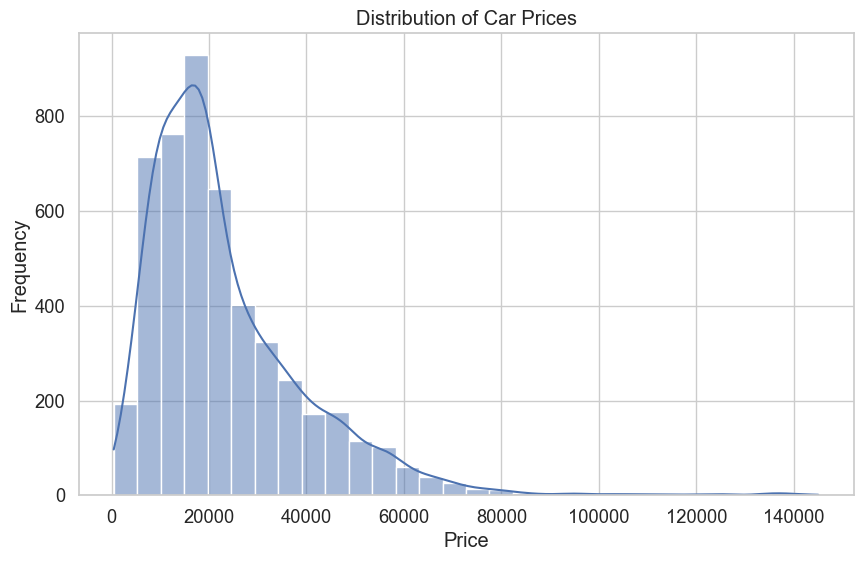

In [19]:
# draw the distribution of the price
plt.figure(figsize=(10, 6))
sns.histplot(train_updated['price'], bins=30, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

The price distribution is right-skewed, indicating that car prices have increasing variance at higher price levels. Linear models work best with normally distributed data and generally perform better when this assumption is met.

**Benefits of using `log(price)` as the dependent variable:**

1. **Reduces Heteroscedasticity**: Car prices often have increasing variance at higher price levels; log transformation stabilizes this variance
2. **Handles Multiplicative Effects**: Captures percentage changes rather than absolute changes, which is more natural for price data
3. **Improves Model Fit**: Often leads to better R² values and improved residual behavior
4. **Interpretability**: Coefficients represent percentage changes in price, making economic interpretation more intuitive

**Important**: When using log-transformed dependent variables, predictions must be transformed back using `np.exp()` to get actual price predictions.


In [21]:
# R-squared of the model with just mileage (log-transformed price)
# Log transformation helps with heteroscedasticity and non-linear relationships
model_sm_mileage = smf.ols('np.log(price) ~ mileage', data=train_updated).fit()
print(f"R-squared (log price ~ mileage): {model_sm_mileage.rsquared:.4f}")

# Compare with original model without log transformation
model_sm_mileage_orig = smf.ols('price ~ mileage', data=train_updated).fit()
print(f"R-squared (price ~ mileage):     {model_sm_mileage_orig.rsquared:.4f}")


R-squared (log price ~ mileage): 0.3601
R-squared (price ~ mileage):     0.2293


The model's R² increased from 22% to 36% with the log transformation, but 36% is still relatively low. Let's explore how we can improve it further by examining the relationship between log-transformed car price and mileage.

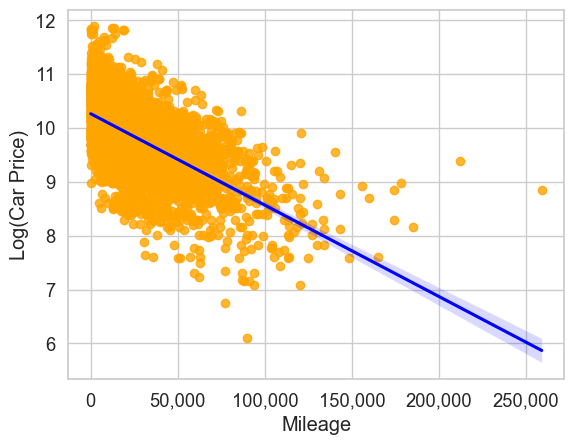

In [40]:
# Relationship between log(price) and mileage
ax = sns.regplot(x=train_updated.mileage, y=np.log(train_updated.price), color='orange', line_kws={'color': 'blue'})
plt.xlabel('Mileage')
plt.ylabel('Log(Car Price)')
ax.xaxis.set_major_formatter('{x:,.0f}')


The plot shows a reasonably linear relationship between mileage and log(price), but the R² of 36% suggests there's still substantial unexplained variation. While the log transformation improved the model from 22% to 36%, we can explore polynomial terms to capture any remaining nonlinear patterns.

#### Quadratic transformation

Add a squared term for `mileage` using the `I()` operator to keep it as a separate predictor.


In [22]:
# Quadratic model with log-transformed price
model_sm_quad = smf.ols('np.log(price) ~ mileage + I(mileage**2)', data=train_updated).fit()
print("Log-transformed price with quadratic mileage term:")
print(f"R-squared: {model_sm_quad.rsquared:.4f}")
model_sm_quad.summary()


Log-transformed price with quadratic mileage term:
R-squared: 0.3825


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     1535.
Date:                Fri, 23 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:30:37   Log-Likelihood:                -4007.5
No. Observations:                4959   AIC:                             8021.
Df Residuals:                    4956   BIC:                             8040.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.3538      0.013    803.018      0.000      10.329      10.379
mileage         -2.452e-05   6.47e-07    -37.919      0.000   -2.58e-05   -2.32e-05
I(mileage ** 2)  8.112e-11   6.06e-12     13.385      0.000    6.92e-11     9.3e-11
==============================================================================
Omnibus:                       25.307   Durbin-Watson:                   0.323
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.219
Skew:                          -0.154   Prob(JB):                     2.03e-06
Kurtosis:                       3.178   Cond. No.                     4.81e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

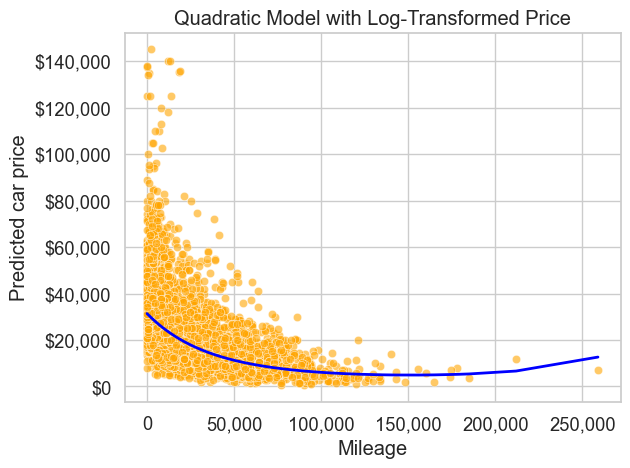

In [23]:
# Visualize the quadratic fit (transform log predictions back to price scale)
pred_price_log = model_sm_quad.predict(train_updated)
pred_price = np.exp(pred_price_log)  # Transform back from log scale

ax = sns.scatterplot(x='mileage', y='price', data=train_updated, color='orange', alpha=0.6)
sns.lineplot(x=train_updated.mileage, y=pred_price, color='blue', linewidth=2)
plt.xlabel('Mileage')
plt.ylabel('Predicted car price')
plt.title('Quadratic Model with Log-Transformed Price')

ax.yaxis.set_major_formatter('${x:,.0f}')

ax.xaxis.set_major_formatter('{x:,.0f}')
plt.show()

#### Cubic transformation

Add a cubic term for additional flexibility.


In [24]:
# Cubic model with log-transformed price
model_sm_cubic = smf.ols('np.log(price) ~ mileage + I(mileage**2) + I(mileage**3)', data=train_updated).fit()
print("Log-transformed price with cubic mileage terms:")
print(f"R-squared: {model_sm_cubic.rsquared:.4f}")
model_sm_cubic.summary()


Log-transformed price with cubic mileage terms:
R-squared: 0.3835


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     1027.
Date:                Fri, 23 Jan 2026   Prob (F-statistic):               0.00
Time:                        09:31:01   Log-Likelihood:                -4003.4
No. Observations:                4959   AIC:                             8015.
Df Residuals:                    4955   BIC:                             8041.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.3730      0.015    714.209      0.000      10.345      10.402
mileage         -2.705e-05   1.09e-06    -24.723      0.000   -2.92e-05   -2.49e-05
I(mileage ** 2)  1.328e-10    1.9e-11      6.985      0.000    9.55e-11     1.7e-10
I(mileage ** 3)  -2.22e-16   7.74e-17     -2.868      0.004   -3.74e-16   -7.02e-17
==============================================================================
Omnibus:                       28.207   Durbin-Watson:                   0.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.444
Skew:                          -0.161   Prob(JB):                     4.04e-07
Kurtosis:                       3.196   Cond. No.                     7.73e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.73e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

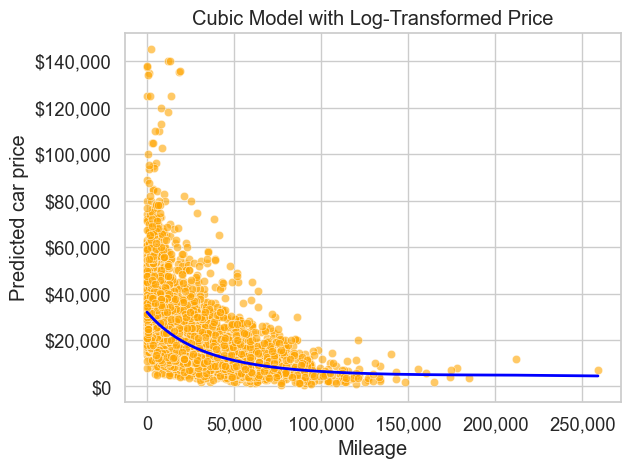

In [25]:
# Visualize the cubic fit (transform log predictions back to price scale)
pred_price_log = model_sm_cubic.predict(train_updated)
pred_price = np.exp(pred_price_log)  # Transform back from log scale

ax = sns.scatterplot(x='mileage', y='price', data=train_updated, color='orange', alpha=0.6)
sns.lineplot(x=train_updated.mileage, y=pred_price, color='blue', linewidth=2)
plt.xlabel('Mileage')
plt.ylabel('Predicted car price')
plt.title('Cubic Model with Log-Transformed Price')

ax.yaxis.set_major_formatter('${x:,.0f}')

ax.xaxis.set_major_formatter('{x:,.0f}')

plt.show()

**Do polynomial transformations work?**

Adding polynomial terms yields:
- **Quadratic model**: R² = 38.2% (improvement of 2.2 percentage points)
- **Cubic model**: R² = 38.3% (improvement of 0.1 percentage points over quadratic)

**Interpretation:**
The quadratic term provides a modest improvement (~2 percentage points), suggesting some nonlinearity exists in the mileage-price relationship. However, the cubic term adds almost nothing (0.1%), indicating diminishing returns. 

While statistically these improvements may be significant, the practical gain is limited. The quadratic transformation is **moderately useful** but not transformative. The cubic term appears to be **overfitting** rather than capturing meaningful patterns. For this dataset, the log transformation itself provides the most substantial improvement, and a simple quadratic term may be sufficient if polynomial features are desired.

#### Putting interaction and transformation together

Combine the interaction term with a quadratic mileage term.


In [44]:
# Full model with interactions and log-transformed price
model_sm_full = smf.ols(
    formula='np.log(price) ~ age*engineSize + mileage + I(mileage**2)',
    data=train_updated,
).fit()

print("Full model with log-transformed price:")
print(f"R-squared: {model_sm_full.rsquared:.4f}")
model_sm_full.summary()


Full model with log-transformed price:
R-squared: 0.7993


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     3944.
Date:                Fri, 23 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:37:33   Log-Likelihood:                -1221.1
No. Observations:                4959   AIC:                             2454.
Df Residuals:                    4953   BIC:                             2493.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.4393      0.019    496.336      0.000       9.402       9.477
age                -0.1396      0.005    -30.210      0.000      -0.149      -0.131
engineSize          0.4634      0.008     58.287      0.000       0.448       0.479
age:engineSize      0.0075      0.002      4.487      0.000       0.004       0.011
mileage         -8.758e-06    4.6e-07    -19.044      0.000   -9.66e-06   -7.86e-06
I(mileage ** 2)  3.237e-11   3.53e-12      9.160      0.000    2.54e-11    3.93e-11
==============================================================================
Omnibus:                      456.087   Durbin-Watson:                   0.491
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1602.553
Skew:                           0.433   Prob(JB):                         0.00
Kurtosis:                       5.647   Cond. No.                     1.35e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# RMSE on test data (transform log predictions back to price scale)
pred_price_log = model_sm_full.predict(test)
pred_price = np.exp(pred_price_log)  # Transform back from log scale


rmse_full = np.sqrt(((test.price - pred_price) ** 2).mean())

print(f"RMSE on test data (log-transformed model): ${rmse_full:,.2f}")



rmse_log_scale = np.sqrt(((np.log(test.price) - pred_price_log) ** 2).mean())
# For comparison, calculate RMSE in log scale too
print(f"RMSE in log scale: {rmse_log_scale:.4f}")

RMSE on test data (log-transformed model): $9,646.67
RMSE in log scale: 0.3425


## Polynomial Features in scikit-learn (same car dataset)

We keep the same train/test split and use `log(price)` to match the statsmodels section.


### Handling Zero and Negative Values with Log Transformations

**The Problem: log(0) is Undefined**

In practice, Python returns `-inf` or throws an error when you try to compute `log(0)`. This is problematic when your data contains zero values.

**Solution: `log1p()` - Best Solution for Most Cases**

Use `np.log1p(x)` which computes `log(1 + x)`:

```python
# Instead of:
y_transformed = np.log(y)  # Fails if y contains 0

# Use:
y_transformed = np.log1p(y)  # Works even when y = 0
```

**Back-transformation:**
```python
# To reverse log1p, use expm1:
y_original = np.expm1(y_transformed)  # Computes exp(x) - 1
```

**Benefits:**
- Handles zero values naturally: `log1p(0) = log(1) = 0`
- More numerically stable for small values
- Common in financial and count data

**Note:** For this car price dataset, all prices are positive, so we can safely use `np.log()` directly.

In [46]:
# Create feature matrix and target vector (log price)
feature_cols = ['mileage', 'engineSize', 'age', 'mpg']
X_train = train_updated[feature_cols]
X_test = test[feature_cols]
y_train = np.log(train_updated['price'])
y_test = np.log(test['price'])
y_train_price = train_updated['price']
y_test_price = test['price']

X_train.head()


,mileage,engineSize,age,mpg
0,11,3.0,0,53.3282
1,10813,3.0,1,53.0430
2,6,3.0,0,53.4379
3,18895,3.0,3,51.5140
4,62953,3.0,5,51.4903


### Train/test split


In [ ]:
# We use the provided train/test split from the dataset.
# Show train/test shapes
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (4000, 2)
Testing set shape: (1000, 2)



### Baseline Model (original Features)

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

# Fit a baseline linear regression model on log(price)
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predict on train and test splits (log scale)
y_pred_baseline = baseline_model.predict(X_test)
y_train_pred_baseline = baseline_model.predict(X_train)

# Evaluate on test and training sets (log scale)
rmse_baseline = root_mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

rmse_train_baseline = root_mean_squared_error(y_train, y_train_pred_baseline)
r2_train_baseline = r2_score(y_train, y_train_pred_baseline)

# Back-transform to price scale (see log-trap note above)
pred_price_baseline = np.exp(y_pred_baseline)
rmse_price_baseline = root_mean_squared_error(y_test_price, pred_price_baseline)

print()
print("Baseline Model Performance (log scale):")
print("Training Set:")
print("RMSE:", rmse_train_baseline)
print("R2:", r2_train_baseline)
print()
print("Testing Set:")
print("RMSE:", rmse_baseline)
print("R2:", r2_baseline)
print("RMSE (price scale):", f"${rmse_price_baseline:,.2f}")



Baseline Model Performance (log scale):
Training Set:
RMSE: 0.3126761090785014
R2: 0.7951679756008143

Testing Set:
RMSE: 0.34009843313619664
R2: 0.759217125194597
RMSE (price scale): $9,802.82


### Transform Features with PolynomialFeatures (`degree = 2`)

In [32]:
from sklearn.preprocessing import PolynomialFeatures

# Create PolynomialFeatures object with degree=2 (includes interaction terms)
poly_2 = PolynomialFeatures(degree=2, include_bias=False)

# Transform the training and testing features
X_train_poly_2 = poly_2.fit_transform(X_train)
X_test_poly_2 = poly_2.transform(X_test)

# Display the transformed feature names
print()
print("Transformed Feature Names:")
print(poly_2.get_feature_names_out())



Transformed Feature Names:
['mileage' 'engineSize' 'age' 'mpg' 'mileage^2' 'mileage engineSize'
 'mileage age' 'mileage mpg' 'engineSize^2' 'engineSize age'
 'engineSize mpg' 'age^2' 'age mpg' 'mpg^2']


#### Linear Model with transformed Features (`degree = 2`)

In [33]:
# Fit a linear regression model on degree-2 polynomial features (log price)
poly_2_model = LinearRegression()
poly_2_model.fit(X_train_poly_2, y_train)

# Predict on train and test splits (log scale)
y_pred_poly_2 = poly_2_model.predict(X_test_poly_2)
y_train_pred_poly_2 = poly_2_model.predict(X_train_poly_2)

# Evaluate on test and training sets (log scale)
rmse_poly_2 = root_mean_squared_error(y_test, y_pred_poly_2)
r2_poly_2 = r2_score(y_test, y_pred_poly_2)

rmse_train_poly_2 = root_mean_squared_error(y_train, y_train_pred_poly_2)
r2_train_poly_2 = r2_score(y_train, y_train_pred_poly_2)

# Back-transform to price scale (see log-trap note above)
pred_price_poly_2 = np.exp(y_pred_poly_2)
rmse_price_poly_2 = root_mean_squared_error(y_test_price, pred_price_poly_2)

print()
print("Polynomial Model Performance (degree=2, log scale):")
print("Training Set:")
print("RMSE:", rmse_train_poly_2)
print("R2:", r2_train_poly_2)
print()
print("Testing Set:")
print("RMSE:", rmse_poly_2)
print("R2:", r2_poly_2)
print("RMSE (price scale):", f"${rmse_price_poly_2:,.2f}")



Polynomial Model Performance (degree=2, log scale):
Training Set:
RMSE: 0.3002407156431113
R2: 0.8111366745155597

Testing Set:
RMSE: 0.30894008525487293
R2: 0.8013151022053762
RMSE (price scale): $8,479.10


### Transform features with PolynomialFeatures (`degree = 3`)

In [34]:
# Create PolynomialFeatures object with degree=3
poly_3 = PolynomialFeatures(degree=3, include_bias=False)

# Transform the training and testing features
X_train_poly_3 = poly_3.fit_transform(X_train)
X_test_poly_3 = poly_3.transform(X_test)

# Display the transformed feature names
print()
print("Transformed Feature Names:")
print(poly_3.get_feature_names_out())



Transformed Feature Names:
['mileage' 'engineSize' 'age' 'mpg' 'mileage^2' 'mileage engineSize'
 'mileage age' 'mileage mpg' 'engineSize^2' 'engineSize age'
 'engineSize mpg' 'age^2' 'age mpg' 'mpg^2' 'mileage^3'
 'mileage^2 engineSize' 'mileage^2 age' 'mileage^2 mpg'
 'mileage engineSize^2' 'mileage engineSize age' 'mileage engineSize mpg'
 'mileage age^2' 'mileage age mpg' 'mileage mpg^2' 'engineSize^3'
 'engineSize^2 age' 'engineSize^2 mpg' 'engineSize age^2'
 'engineSize age mpg' 'engineSize mpg^2' 'age^3' 'age^2 mpg' 'age mpg^2'
 'mpg^3']


#### Linear Model with transformed Features (`degree = 3`)

In [35]:
# Fit a linear regression model on degree-3 polynomial features (log price)
poly_3_model = LinearRegression()
poly_3_model.fit(X_train_poly_3, y_train)

# Predict on train and test splits (log scale)
y_pred_poly_3 = poly_3_model.predict(X_test_poly_3)
y_pred_train_poly_3 = poly_3_model.predict(X_train_poly_3)

# Evaluate on test and training sets (log scale)
rmse_poly_3 = root_mean_squared_error(y_test, y_pred_poly_3)
r2_poly_3 = r2_score(y_test, y_pred_poly_3)

rmse_poly_3_train = root_mean_squared_error(y_train, y_pred_train_poly_3)
r2_poly_3_train = r2_score(y_train, y_pred_train_poly_3)

# Back-transform to price scale (see log-trap note above)
pred_price_poly_3 = np.exp(y_pred_poly_3)
rmse_price_poly_3 = root_mean_squared_error(y_test_price, pred_price_poly_3)

print()
print("Polynomial Model Performance (degree=3, log scale):")
print("Training Set:")
print("RMSE:", rmse_poly_3_train)
print("R2:", r2_poly_3_train)
print()
print("Testing Set:")
print("RMSE:", rmse_poly_3)
print("R2:", r2_poly_3)
print("RMSE (price scale):", f"${rmse_price_poly_3:,.2f}")



Polynomial Model Performance (degree=3, log scale):
Training Set:
RMSE: 0.3811542627298689
R2: 0.695624268973846

Testing Set:
RMSE: 0.3804705656720708
R2: 0.6986588360960538
RMSE (price scale): $12,105.56


### `degree = 4`


In [36]:
# Use polynomial degree of 4 to see if it improves the model
poly_4 = PolynomialFeatures(degree=4, include_bias=False)

# Transform the training and testing features
X_train_poly_4 = poly_4.fit_transform(X_train)
X_test_poly_4 = poly_4.transform(X_test)

# Create a linear regression model for the polynomial features
poly_4_model = LinearRegression()

# Train the model on the transformed features
poly_4_model.fit(X_train_poly_4, y_train)

# Make predictions on the test and training sets (log scale)
y_pred_poly_4 = poly_4_model.predict(X_test_poly_4)
y_pred_train_poly_4 = poly_4_model.predict(X_train_poly_4)

# Evaluate the polynomial model (log scale)
rmse_poly_4 = root_mean_squared_error(y_test, y_pred_poly_4)
r2_poly_4 = r2_score(y_test, y_pred_poly_4)

rmse_poly_4_train = root_mean_squared_error(y_train, y_pred_train_poly_4)
r2_poly_4_train = r2_score(y_train, y_pred_train_poly_4)

# Back-transform to price scale (see log-trap note above)
pred_price_poly_4 = np.exp(y_pred_poly_4)
rmse_price_poly_4 = root_mean_squared_error(y_test_price, pred_price_poly_4)

print()
print("Polynomial Model Performance (degree=4, log scale):")
print("Training Set:")
print("RMSE:", rmse_poly_4_train)
print("R2:", r2_poly_4_train)
print()
print("Testing Set:")
print("RMSE:", rmse_poly_4)
print("R2:", r2_poly_4)
print("RMSE (price scale):", f"${rmse_price_poly_4:,.2f}")



Polynomial Model Performance (degree=4, log scale):
Training Set:
RMSE: 0.4825146268287559
R2: 0.5122138946437124

Testing Set:
RMSE: 0.48497471912881407
R2: 0.5103852040335006
RMSE (price scale): $14,132.89


In [37]:
# get the feature names for the polynomial degree 4 model
print("\nNumber of Features:", len(poly_4.get_feature_names_out()))
print("\nTransformed Feature Names:")
print(poly_4.get_feature_names_out())



Number of Features: 69

Transformed Feature Names:
['mileage' 'engineSize' 'age' 'mpg' 'mileage^2' 'mileage engineSize'
 'mileage age' 'mileage mpg' 'engineSize^2' 'engineSize age'
 'engineSize mpg' 'age^2' 'age mpg' 'mpg^2' 'mileage^3'
 'mileage^2 engineSize' 'mileage^2 age' 'mileage^2 mpg'
 'mileage engineSize^2' 'mileage engineSize age' 'mileage engineSize mpg'
 'mileage age^2' 'mileage age mpg' 'mileage mpg^2' 'engineSize^3'
 'engineSize^2 age' 'engineSize^2 mpg' 'engineSize age^2'
 'engineSize age mpg' 'engineSize mpg^2' 'age^3' 'age^2 mpg' 'age mpg^2'
 'mpg^3' 'mileage^4' 'mileage^3 engineSize' 'mileage^3 age'
 'mileage^3 mpg' 'mileage^2 engineSize^2' 'mileage^2 engineSize age'
 'mileage^2 engineSize mpg' 'mileage^2 age^2' 'mileage^2 age mpg'
 'mileage^2 mpg^2' 'mileage engineSize^3' 'mileage engineSize^2 age'
 'mileage engineSize^2 mpg' 'mileage engineSize age^2'
 'mileage engineSize age mpg' 'mileage engineSize mpg^2' 'mileage age^3'
 'mileage age^2 mpg' 'mileage age mpg^2' 'm

### Putting all together

In [38]:
# Summarize model performance side by side
models = ['Baseline', 'Polynomial Degree 2', 'Polynomial Degree 3', 'Polynomial Degree 4']
features = [
    X_train.shape[1],
    len(poly_2.get_feature_names_out()),
    len(poly_3.get_feature_names_out()),
    len(poly_4.get_feature_names_out()),
]
training_rmse = [rmse_train_baseline, rmse_train_poly_2, rmse_poly_3_train, rmse_poly_4_train]
testing_rmse = [rmse_baseline, rmse_poly_2, rmse_poly_3, rmse_poly_4]
testing_rmse_price = [rmse_price_baseline, rmse_price_poly_2, rmse_price_poly_3, rmse_price_poly_4]
training_r2 = [r2_train_baseline, r2_train_poly_2, r2_poly_3_train, r2_poly_4_train]
testing_r2 = [r2_baseline, r2_poly_2, r2_poly_3, r2_poly_4]

model_comparison = pd.DataFrame(
    {
        'Model': models,
        'Features': features,
        'Training RMSE (log)': training_rmse,
        'Testing RMSE (log)': testing_rmse,
        'Testing RMSE (price)': testing_rmse_price,
        'Training R2': training_r2,
        'Testing R2': testing_r2,
    }
)

model_comparison


,Model,Features,Training RMSE (log),Testing RMSE (log),Testing RMSE (price),Training R2,Testing R2
0,Baseline,4,0.312676,0.340098,9802.816771,0.795168,0.759217
1,Polynomial Degree 2,14,0.300241,0.308940,8479.095395,0.811137,0.801315
2,Polynomial Degree 3,34,0.381154,0.380471,12105.564864,0.695624,0.698659
3,Polynomial Degree 4,69,0.482515,0.484975,14132.893458,0.512214,0.510385


When the polynomial degree increases, training error typically decreases because the model becomes more flexible. However, test performance may stop improving—or even get worse—which indicates overfitting. In our results, degree 3 and 4 appear to overfit, while degree 2 provides the best generalization. 

Next, we’ll implement the degree-2 model using a scikit-learn `Pipeline`.

In [39]:
# Pipeline for the best model (degree=2)
from sklearn.pipeline import Pipeline

poly2_pipeline = Pipeline(
    steps=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('model', LinearRegression()),
    ]
)

poly2_pipeline.fit(X_train, y_train)
pred_log_pipe = poly2_pipeline.predict(X_test)
rmse_log_pipe = root_mean_squared_error(y_test, pred_log_pipe)
rmse_price_pipe = root_mean_squared_error(y_test_price, np.exp(pred_log_pipe))

print("Pipeline (degree=2) RMSE (log):", rmse_log_pipe)
print("Pipeline (degree=2) RMSE (price):", f"${rmse_price_pipe:,.2f}")


Pipeline (degree=2) RMSE (log): 0.30894008525487293
Pipeline (degree=2) RMSE (price): $8,479.10


### Key takeaway:

In `scikit-learn`, the built-in `PolynomialFeatures` transformer is somewhat “all or nothing”: by default, it generates **all** polynomial terms (including interactions) up to a certain degree. You can toggle:

* `interaction_only=True` to generate only cross-terms
* `include_bias=False` to exclude the constant (bias) term,
* `degree` to control how high the polynomial powers go.

However, if you want **fine-grained control** over exactly which terms get generated (for example, only certain interaction terms, or only a subset of polynomial terms), you will need to create those features manually or write a custom transformer (skipped for beginner level)

And also when using `PolynomialFeatures` (or any other scikit-learn transformer), the fitting step is always done on the training data—not on the test data. This is a fundamental principle of machine learning pipelines: we do not use the test set for any part of model training (including feature encoding, feature generation, scaling, etc.). 

## Summary

Feature transformations extend the capabilities of linear regression by capturing nonlinear relationships while maintaining the interpretability and computational efficiency of linear models.

**Key Takeaways:**

1. **Exploratory Data Analysis First**: Use EDA to examine relationships between features and the target variable. Visualizations help identify nonlinear patterns that suggest transformation needs.

2. **Log Transformation Benefits**:
   - Applies to both the target variable and predictors
   - Reduces heteroscedasticity (non-constant variance)
   - Handles multiplicative effects and percentage changes
   - Improves model fit for skewed distributions

3. **Polynomial Features**:
   - Common approach for capturing nonlinear relationships
   - Higher degrees increase model flexibility
   - Can model curved patterns (quadratic, cubic, etc.)

4. **Bias-Variance Trade-off**:
   - Adding predictors/features typically decreases bias (underfitting)
   - But increases variance (risk of overfitting)
   - More complex models fit training data better but may generalize poorly

5. **Model Evaluation is Critical**:
   - Always compare training and test performance
   - Large gaps indicate overfitting
   - Use test metrics to guide model selection

**Best Practices:**
- Start simple, add complexity gradually
- Monitor both training and test performance
- Choose models that generalize well over those that merely fit training data